In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 20 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        state = env.reset()
        
        # Update policy
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
     
        # Sample first action from epsilon-greedy(Q)
        action = np.random.choice(np.arange(env.action_space.n), p = policy(state))
        while True:            
            # Take one step
            next_state, reward, done, _ = env.step(action)
            
            # Sample another action from epsilon-greedy(Q)
            next_action = np.random.choice(np.arange(env.action_space.n), p = policy(next_state))
            
            # Update Q
            td_delta = reward + discount_factor * Q[next_state][next_action] - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            # Write stats
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1

            # Break condition
            if done:
                break
                
            # Next step
            state = next_state
            action = next_action
        
        # Update epsilon
        epsilon = epsilon * (i_episode + 1) / (i_episode + 2)   
        
    return Q, stats

In [5]:
Q, stats = sarsa(env, 200)

Episode 200/200.

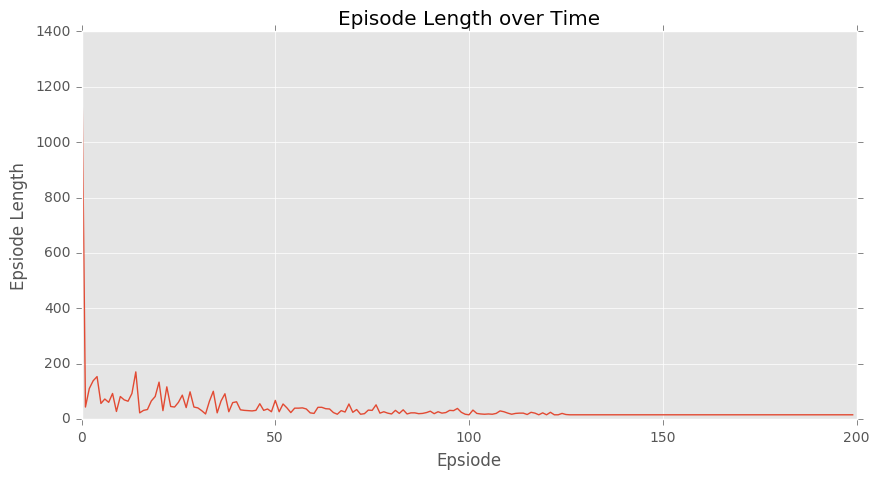

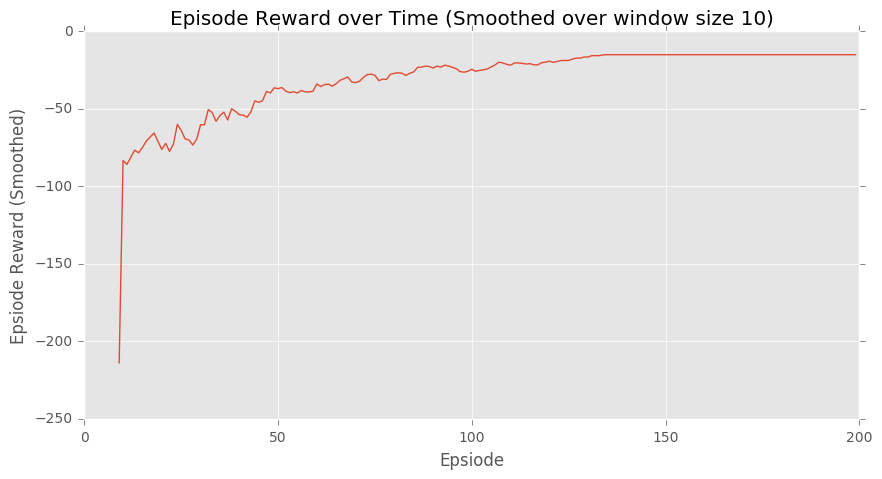

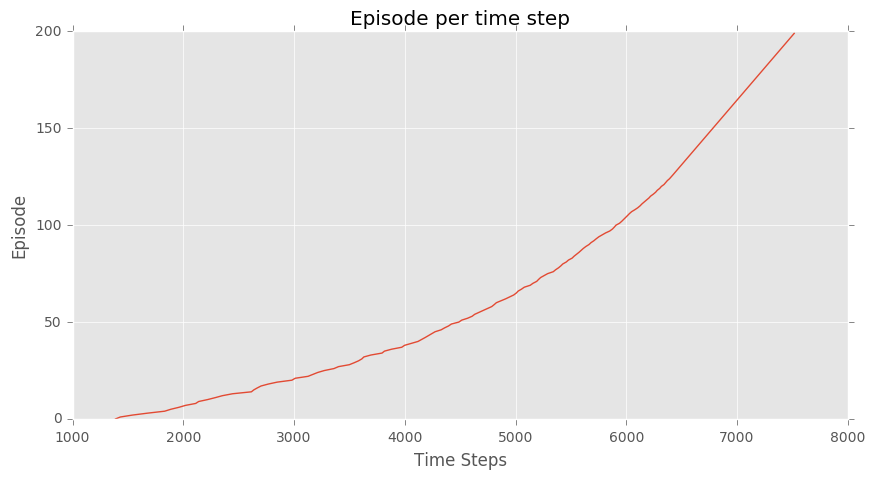

(<matplotlib.figure.Figure at 0x106d28e48>,
 <matplotlib.figure.Figure at 0x111524cc0>)

In [6]:
plotting.plot_episode_stats(stats)

In [8]:
stats.episode_lengths[-10:]

array([ 15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.,  15.])

Ends up at ~20 steps. Increasing episodes to 2000 doesn't improve it much. I suspect the learning rate is too much.

## Implement Sarsa(lambda)
Does it converge faster than Sarsa(0)?

In [9]:
def sarsa_lambda(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, l = 0.9):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        l: Lambda for sarsa(lambda)
         
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 20 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        
        # Initialize env and eligibility trace
        state = env.reset()
        E = defaultdict(lambda: np.zeros(env.action_space.n))
        
        # Update policy
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        
        # Sample the first action from epsilon-greedy(Q)
        action = np.random.choice(np.arange(env.action_space.n), p = policy(state))

        while True:           
            # Take one step
            next_state, reward, done, _ = env.step(action)
            
            # Sample another action from epsilon-greedy(Q)
            next_action = np.random.choice(np.arange(env.action_space.n), p = policy(next_state))
            
            # Update eligibility trace
            E[state][action] += 1/l
            for s in E:
                for a in range(env.action_space.n):
                    E[s][a] = E[s][a] * l
            
            # Update Q
            td_delta = reward + discount_factor * Q[next_state][next_action] - Q[state][action]
            for s in E:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * E[s][a] * td_delta
            
            # Write stats
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1

            # Break condition
            if done:
                break
                
            # Next step
            state = next_state
            action = next_action
        
        # Update epsilon
        epsilon = epsilon * (i_episode + 1) / (i_episode + 2)   
    return Q, stats

In [12]:
Q, stats = sarsa_lambda(env, 200, alpha=0.5)

Episode 200/200.

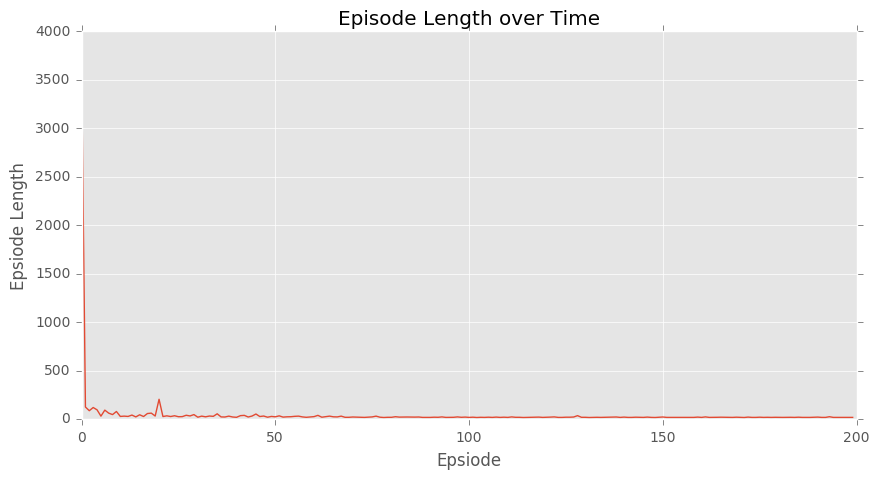

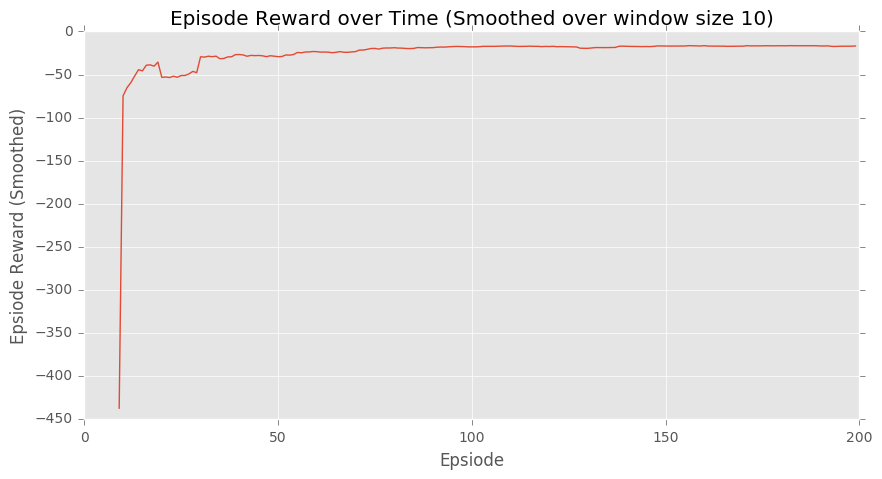

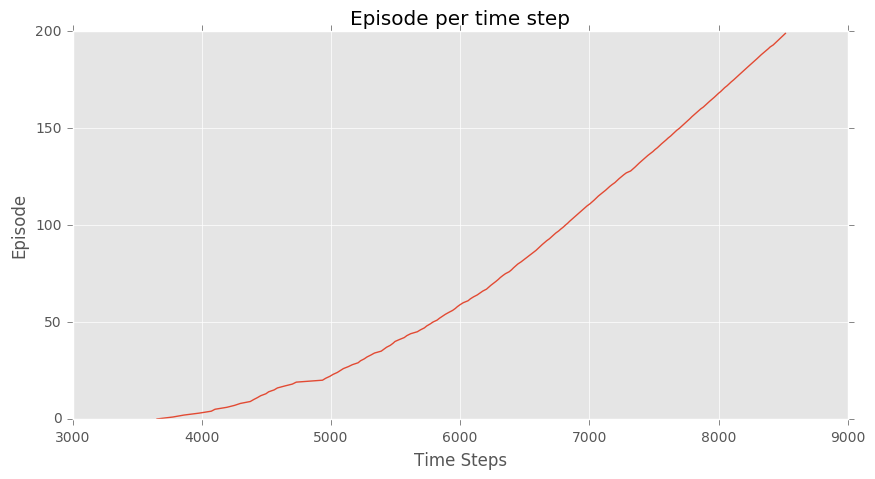

(<matplotlib.figure.Figure at 0x1119c8048>,
 <matplotlib.figure.Figure at 0x1125cbb70>)

In [13]:
plotting.plot_episode_stats(stats)

In [14]:
stats.episode_lengths[-10:]

array([ 19.,  16.,  16.,  23.,  16.,  16.,  16.,  15.,  16.,  16.])

Sarsa(lambda) result seems to be a lot more volatile than sarsa(0). Why is that?

Looks like sarsa(lambda) is easier to be led astray during exploration. Is this because any unwanted fluctuation (possibly caused by too high a learning rate) is propogated through out the entire trace in sarsa(lambda), while in sarsa(0) it only "contaminate" one previous step?

__With smaller learning rate it is behaving much better!__

__Success!__